In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter

import pandas as pd
import numpy as np
from scipy import ndimage, signal
from scipy.linalg import cho_solve, solve_triangular

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from world_rowing import api, livetracker, utils

data_store = 'live_tracker.h5'

In [3]:
with pd.HDFStore(data_store) as store:
    df_names = store.keys()
    races = store['races']
    events = store['events']
    competitions = store['competitions']
    race_results = store['race_results'].reset_index(0)
    
races = utils.merge(
    (races.reset_index(), events, competitions, api.get_boat_types()),
    how='left',
    left_on=('eventId', 'competitionId', 'boatClassId'),
    right_on='id',
    suffixes=(
        (None, '_event'),
        (None, '_competition'),
        (None, '_boat_class')
    )
)

races['full_name'] = races.DisplayName_competition.str.cat(
    [
        races.DisplayName_event,
        races.DisplayName
    ],
    sep='/'
)
race_names = races.set_index('full_name').id

In [4]:
livetracker_names = [f for f in df_names if 'livetracker' in f]
with pd.HDFStore(data_store) as store:
    livetracker_data = {
        f[13:]: store[f] for f in livetracker_names
    }

In [5]:
keep_cols = [
    'currentPosition', 'distanceTravelled', 'distanceFromLeader',
    'strokeRate', 'metrePerSecond'
]

In [6]:
(race_name, live_data), *_ = livetracker_data.items()
live_data.columns.levels[0]

Index(['currentPosition', 'distanceTravelled', 'distanceFromLeader',
       'strokeRate', 'metrePerSecond', 'time', 'GMT', 'PGMT'],
      dtype='object')

In [7]:
race_results['total_seconds'] = race_results.ResultTime.dt.total_seconds()
race_class = races.set_index('id').DisplayName_boat_class

est_times = {}
rec_times = {}
race_live_data = {}
for race_name, live_data in tqdm(livetracker_data.items()):
    race_id = race_names[race_name]
    if race_id in race_results.index:
        est_times[race_id] = live_data.iloc[-1].unstack(0).time.sort_index()
        rec_times[race_id] = race_results.loc[race_id].set_index('Country').total_seconds
        diffs = est_times[race_id] - rec_times[race_id]
        if (abs(diffs.mean()) < 2) and (diffs.std() < 1):
            gmt = api.find_world_best_time(
                boat_class=race_class[race_id]
            ).ResultTime.total_seconds()
            race_live_data[race_id] = livetracker.calculate_pgmts(
                live_data[keep_cols].copy(), gmt
            )
    
len(race_live_data)

  0%|          | 0/378 [00:00<?, ?it/s]

208

In [8]:
live_races = races.loc[
    races.id.isin(race_live_data)
].set_index('id')

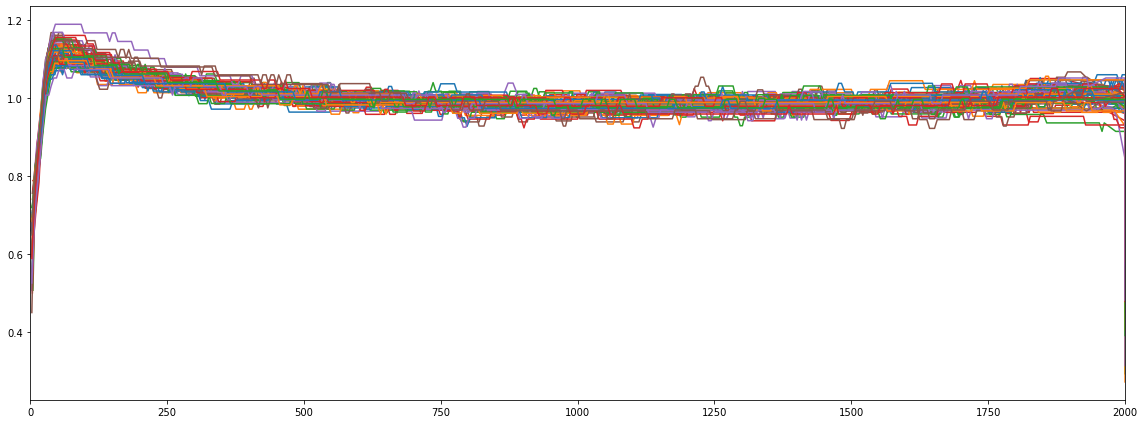

In [9]:
boat = 'LW2x'
class_boat_races = live_races.groupby('DisplayName_boat_class')

colors = sns.color_palette(n_colors=6)

f, axes = plt.subplots(1, figsize=(16, 6), sharex=True, sharey=True)

for race_id in class_boat_races.get_group(boat).index:
    live_data = race_live_data[race_id]
    ranks = race_results.loc[race_id].set_index('Country').Rank
    winner = ranks.index[ranks.argmin()]
    winner_pgmt = live_data.PGMT[winner].iloc[-1]
    live_data
    for cnt, rank in ranks.items():
        axes.plot(
            live_data.distanceTravelled[cnt],
            live_data.metrePerSecond[cnt] / live_data.metrePerSecond[cnt].mean(),
            color=colors[rank-1]
        )
        
# ax.set_ylim(0.4, 2)
axes.set_xlim(0, 2000)
f.tight_layout()
f.subplots_adjust(hspace=0.03, wspace=0.03)
        

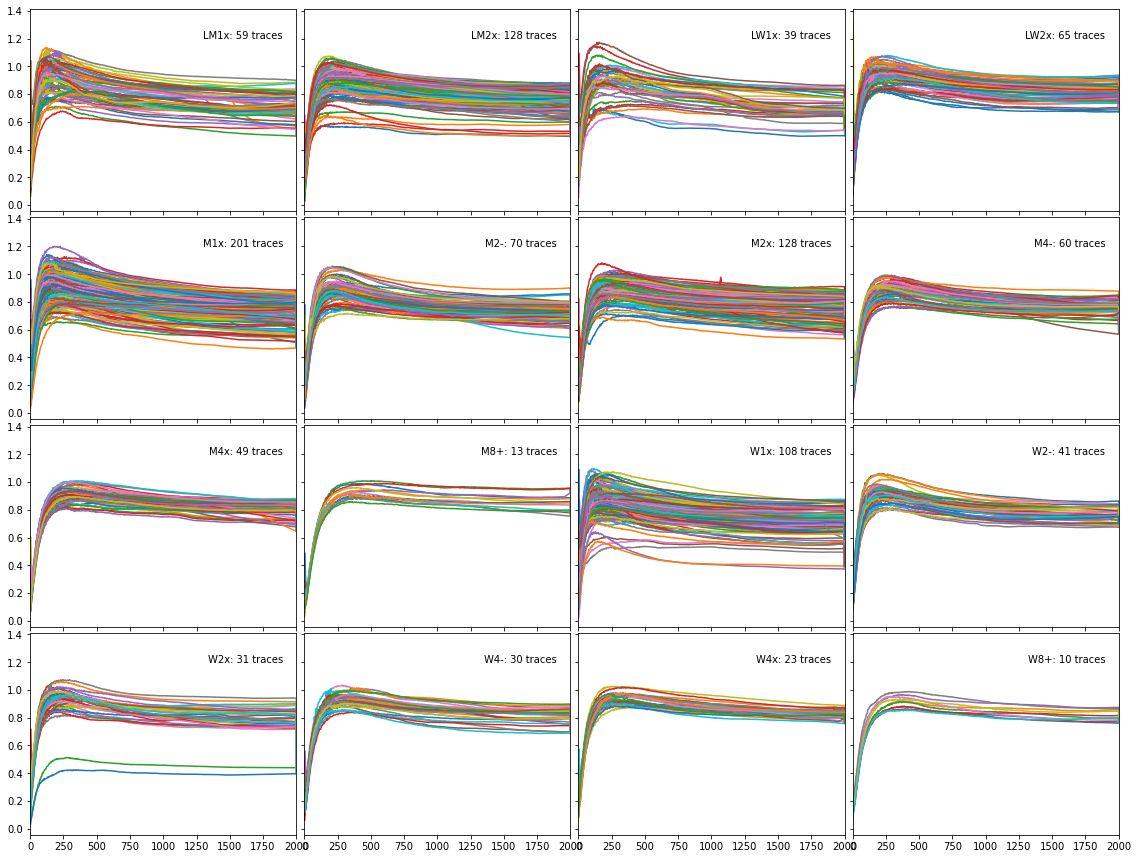

In [12]:
class_boat_races = live_races.groupby('DisplayName_boat_class')
shape = (4, 4)
boat_classes = [
    'LM1x', 'LM2x', 'LW1x', 'LW2x', 
    'M1x', 'M2-', 'M2x', 'M4-', 'M4x', 'M8+', 
    'W1x', 'W2-', 'W2x', 'W4-', 'W4x', 'W8+'
]
n = np.multiply(*shape)

f, axes = plt.subplots(*shape, figsize=(16, 12), sharex=True, sharey=True)
for i, boat in enumerate(boat_classes):
    ind = np.unravel_index(i, shape)
    ax = axes[ind]
    n_races = 0
    for race_id in class_boat_races.get_group(boat).index:
        live_data = race_live_data[race_id]
        ax.plot(
            live_data.distanceTravelled,
            (
                live_data.PGMT
#                 / live_data.PGMT.iloc[-1]
            )**3
        )
        n_races += live_data.PGMT.columns.size
        
    ax.text(
        1900, 1.2, 
        f"{boat}: {n_races} traces", 
        ha='right')
        
        
# ax.set_ylim(0.4, 2)
ax.set_xlim(0, 2000)
f.tight_layout()
f.subplots_adjust(hspace=0.03, wspace=0.03)
f.savefig("pgmt_profiles.png")

# Downloading data 

In [13]:
competitions = api.get_worldrowing_records(
    'competition', 
    filter=(
        ('Year', tuple(range(2008, 2022))),
        ('IsFisa', 1)
    )
)

In [43]:
competition_races, errors = utils.map_concurrent(
    api.get_competition_races,
    dict(
        zip(
            competitions.index, 
            zip(competitions.index)
        )
    )
)
races = pd.concat(
    competition_races, axis=0,
    names=['competitionId', 'id']
).reset_index(0)
races.shape

  0%|          | 0/217 [00:00<?, ?it/s]

,competitionId,eventId,racePhaseId,raceStatusId,genderId,RscCode,DisplayName,RaceNr,IsStarted,Date,DateString,Progression,Rescheduled,RescheduledFrom
id,,,,,,,,,,,,,,
818644e8-73ec-4eaf-bab6-0bb877771afd,0915aa2b-6714-4cbe-8f79-89ef31952647,10c06e13-a5b0-417f-afd6-adaa92738b4e,cd3d5ca1-5aed-4146-b39b-a192ae6533f1,182f6f15-8e78-41c3-95b3-8b006af2c6a1,dae73748-90c9-4a49-9d94-4d4810fa457e,ROWWSCULL1--J---------HEAT000100--,H1,22,None,2014-08-06 17:27:00,None,"1-3->Q, 4..->R",0.0,None
1579d07a-7f44-4424-8213-b2b8b2d2dbab,0915aa2b-6714-4cbe-8f79-89ef31952647,10c06e13-a5b0-417f-afd6-adaa92738b4e,cd3d5ca1-5aed-4146-b39b-a192ae6533f1,182f6f15-8e78-41c3-95b3-8b006af2c6a1,dae73748-90c9-4a49-9d94-4d4810fa457e,ROWWSCULL1--J---------HEAT000200--,H2,23,None,2014-08-06 17:34:00,None,"1-3->Q, 4..->R",0.0,None
fe51df7a-f1ca-4d02-ba8a-eb42fbf3290b,0915aa2b-6714-4cbe-8f79-89ef31952647,10c06e13-a5b0-417f-afd6-adaa92738b4e,cd3d5ca1-5aed-4146-b39b-a192ae6533f1,182f6f15-8e78-41c3-95b3-8b006af2c6a1,dae73748-90c9-4a49-9d94-4d4810fa457e,ROWWSCULL1--J---------HEAT000300--,H3,24,None,2014-08-06 17:41:00,None,"1-3->Q, 4..->R",0.0,None
5c1c969d-b4e0-4663-8ee9-1580386b402c,0915aa2b-6714-4cbe-8f79-89ef31952647,10c06e13-a5b0-417f-afd6-adaa92738b4e,cd3d5ca1-5aed-4146-b39b-a192ae6533f1,182f6f15-8e78-41c3-95b3-8b006af2c6a1,dae73748-90c9-4a49-9d94-4d4810fa457e,ROWWSCULL1--J---------HEAT000400--,H4,25,None,2014-08-06 17:48:00,None,"1-3->Q, 4..->R",0.0,None
39983c51-9854-4e18-94bd-f4096d09501f,0915aa2b-6714-4cbe-8f79-89ef31952647,10c06e13-a5b0-417f-afd6-adaa92738b4e,cd3d5ca1-5aed-4146-b39b-a192ae6533f1,182f6f15-8e78-41c3-95b3-8b006af2c6a1,dae73748-90c9-4a49-9d94-4d4810fa457e,ROWWSCULL1--J---------HEAT000500--,H5,26,None,2014-08-06 17:55:00,None,"1-3->Q, 4..->R",0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327a32df-3d04-48a1-9ad0-88ee38ee7917,fd250598-5041-48a5-9ac1-590221f70d4a,c1ec9c16-85e2-4741-b090-863c32eda80f,e6693585-d2cf-464c-9f8e-b2e531b26400,182f6f15-8e78-41c3-95b3-8b006af2c6a1,5beae5a3-10e4-4d33-96e5-c1a9f612dd54,ROWMSCULL1--J---------SFNL000200--,SA/B 2,68,None,2018-10-10 10:24:00,2018-10-10 10:24:00-03:00,"1-2->FA, 3..->FB",0.0,None
81fb8ece-6db0-4ae2-9bcc-39253c9e11fb,fd250598-5041-48a5-9ac1-590221f70d4a,c1ec9c16-85e2-4741-b090-863c32eda80f,e0fc3320-cd66-43af-a5b5-97afd55b2971,182f6f15-8e78-41c3-95b3-8b006af2c6a1,5beae5a3-10e4-4d33-96e5-c1a9f612dd54,ROWMSCULL1--J---------FNL-000400--,FD,69,None,2018-10-10 10:30:00,2018-10-10 10:30:00-03:00,None,0.0,None
c008909c-c798-4408-b32b-0cb33bcf4466,fd250598-5041-48a5-9ac1-590221f70d4a,c1ec9c16-85e2-4741-b090-863c32eda80f,e0fc3320-cd66-43af-a5b5-97afd55b2971,182f6f15-8e78-41c3-95b3-8b006af2c6a1,5beae5a3-10e4-4d33-96e5-c1a9f612dd54,ROWMSCULL1--J---------FNL-000300--,FC,70,None,2018-10-10 10:36:00,2018-10-10 10:36:00-03:00,None,0.0,None


In [16]:
competition_events, errors = utils.map_concurrent(
    api.get_competition_events,
    dict(
        zip(
            competitions.index, 
            zip(competitions.index)
        )
    )
)
events = pd.concat(
    competition_events, axis=0,
    names=['competitionId', 'id']
).reset_index(0, drop=True)
events.shape

  0%|          | 0/217 [00:00<?, ?it/s]

,competitionId,competitionTypeId,boatClassId,RscCode,DisplayName
id,,,,,
1a6b9c89-5644-4361-af7c-45296cf2080c,0a0567f8-c88e-499e-9f19-7bed485c0047,a99cd5f6-ab8d-473d-8d56-87a0740a5f38,b61f430f-d4ee-48e0-a632-95b9194ccb16,ROWWSCULL1--PR1-------------------,PR1 Women's Single Sculls
1bf3b136-3787-4cfe-91db-ac39d21aa55e,0a0567f8-c88e-499e-9f19-7bed485c0047,a99cd5f6-ab8d-473d-8d56-87a0740a5f38,843310e2-f28c-41a7-90e9-b6f8c289b154,ROWXSCULL2--PR2-------------------,PR2 Mixed Double Sculls
95e70512-f405-4e41-970e-78c035c392cc,0a0567f8-c88e-499e-9f19-7bed485c0047,a99cd5f6-ab8d-473d-8d56-87a0740a5f38,d7365b40-b544-480b-aa99-b0ffad7a13e9,ROWMSCULL1--PR1-------------------,PR1 Men's Single Sculls
9b18489e-4750-4e10-a829-99cca5dcb719,0a0567f8-c88e-499e-9f19-7bed485c0047,a99cd5f6-ab8d-473d-8d56-87a0740a5f38,b6bcf280-a57c-4a6a-96fb-91e6a1355002,ROWXCOXED4--PR3-------------------,PR3 Mixed Coxed Four
1fdd0989-006c-4795-bd05-cfd5de968613,0029c3b2-ce71-431a-b250-fdf503cc66c6,0df896fd-4d8a-48c4-9767-5d3bb07b4274,be5a6d89-d55b-4316-9366-7ed1ef0f307b,ROWMSCULL4--U23-------------------,U23 Men's Quadruple Sculls
...,...,...,...,...,...
fe6a6711-f4c1-4a25-bfaa-8709b48c5ec8,fe0db63a-247a-4e84-95a8-09a266818c43,d140f900-ebba-4d76-ad17-41ab15bd2b37,16946db9-72f2-4375-a797-a26fd485dd26,ROWWSCULL2------------------------,Women's Double Sculls
54223db9-f01b-441f-b315-f30a04d08d64,feef7ef3-def4-4546-a840-a5d1f7a812e0,bf917415-19ab-408c-a3c2-315d7ff12563,b6bcf280-a57c-4a6a-96fb-91e6a1355002,ROWXCOXED4--PR3-------------------,PR3 Mixed Coxed Four
71eeff6c-6e29-4142-967f-ddb2a4c437be,feef7ef3-def4-4546-a840-a5d1f7a812e0,bf917415-19ab-408c-a3c2-315d7ff12563,d7365b40-b544-480b-aa99-b0ffad7a13e9,ROWMSCULL1--PR1-------------------,PR1 Men's Single Sculls


In [44]:
races = utils.merge(
    (races.reset_index(), events, competitions, api.get_boat_types()),
    how='left',
    left_on=('eventId', 'competitionId', 'boatClassId'),
    right_on='id',
    suffixes=(
        (None, '_event'),
        (None, '_competition'),
        (None, '_boat_class')
    )
)

for col, dtype in races.dtypes.items():
    races[col] = races[col].astype(
        str if dtype == np.dtype('O') else dtype
    )
    
races.to_hdf(data_store, 'races')
races.shape

(14376, 32)

In [45]:
data_store = 'race_data.h5'

In [63]:
competition_ids = competitions.index.unique()

def get_competition_results(comp_id):
    return api.get_race_results(competition_id=comp_id)

comp_results, errors = utils.map_concurrent(
    get_competition_results, 
    {c: (c,) for c in competition_ids}
)

race_results = pd.concat({
    k: df for k, df in comp_results.items() if len(df)
}, 
    names = ['competition_id', 'race_id', 'id'],
    axis=0).reset_index(0)

race_results.to_hdf(data_store, 'race_results')

  0%|          | 0/217 [00:00<?, ?it/s]

In [71]:
race_live_data, errors = utils.map_concurrent(
    livetracker.get_race_livetracker,
    {rid: (rid,) for rid in races.id},
    max_workers=20,
)

  0%|          | 0/14376 [00:00<?, ?it/s]

/home/matthew/venv/concr38/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [76]:
with open('livetracker_errors.txt', 'w') as f:
    f.writelines(list(errors))

In [72]:
races_id = races.set_index('id')
with pd.HDFStore(data_store) as store:
    for race_id, livetrack in race_live_data.items():
        live_data, results, intermediates = livetrack
        if len(live_data):
            event_id = races_id.loc[race_id].eventId
            key = "/".join([
                'livetracker', 
                race_id
            ])
            store['livetracker/live_data/' + race_id] = live_data
            store['livetracker/results/' + race_id] = results
            store['livetracker/intermediates/' + race_id] = intermediates

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '7aa27356-19fd-4f10-a18d-4be535d5728c'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['id', 'boatId', 'countryId', 'worldBestTimeId', 'raceId', 'DisplayName',
       'InvalidMarkResult', 'Remark'],
      dtype='object')]

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '5d2490a0-b531-

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '26ed1146-644b-4ddd-b2ff-ae44c3e9f708'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '55bc139b-4b3c-4d1b-94bb-159f745d787a'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '93d061ca-614d-414a-b8b1-ad21216de6e9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8730742c-a169-4895-a71b-1a763c05b851'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'e2b2535a-e932-4fdc-a70d-239d0250090d'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'ab4a6ac0-188f-4948-a600-93ced9b73f9d'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'd51f0292-d7c8-47da-b3c0-0704d840f693'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '42dbf149-2253-41bd-a2e7-d3d23193d6b5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '824cbdea-0db5-406d-8902-08f505275788'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'af58b42e-7447-4530-a8b8-567326c7208e'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '19696042-66fc-41d6-9b5c-8cf6bf2bcdd8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'c5c1237a-5d4c-4e14-bfa0-3de464f23b87'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'c3dfed6a-4338-42fa-9f59-7d9d040d189d'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '311baf77-66fe-45f3-b535-e86c21536af7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '777b8ab9-17b0-45a3-b681-81c0e12c748a'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'db43c8f0-ac8b-4d7c-954f-69a1183bb665'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'd5e1457f-01b6-446b-9089-1472db7da04c'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '68556a36-1852-4b0a-8e53-600268e163b7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '94446bfa-4584-46b2-bd76-5b6e8e3fb17d'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4515000e-4f64-4ad8-a1d5-fd51c5f8a546'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'e6281cb8-7dd9-475c-8eb7-0e371d67d3fc'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '912b3a60-aea4-4928-b5fc-02872032fee2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'b1c5b547-fdfc-4e8f-ac4a-84ec98a35dbc'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'beb5ff53-4f40-4a46-b643-93e17e8c26c2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8974b47c-ee61-4f97-a64d-7baa760124d6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '26567f43-2567-4ad9-981e-bdd20ab5b961'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4353b3aa-8f46-45e2-acbd-28a6ac533a4d'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'adeffcc9-d626-4f09-9d0d-5f7510a5d0ef'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0eb5eb6f-7f9a-43e5-92d2-59368a8503d3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '7b5303bd-dbc1-4f01-881f-016bc3ef3831'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '3cd73034-d2fc-4a62-b6a0-2b7299a1b778'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'dcb6833b-5617-40b0-bc50-25f2c29206f2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'b60892bc-68cd-4646-a6ef-bdd27a51e9ca'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'f65323cc-616e-4921-92d1-bf82bfc51cf7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0f9ef4b3-87a9-432f-9ef3-26cf7ad8f257'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '3fa7ca60-81b9-4eae-a125-8e5cb58d46e8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '14e6d09a-f74d-4d3f-947f-77b4b53796ad'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'c83874bb-948f-435c-91af-c34b51d7c997'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '5e917218-4882-46f0-a147-f6afa7fee767'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0dcc390a-80d8-489e-b81f-2077c1c8913e'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0b603d1e-99a2-4db8-af43-aa335a277430'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0b31fadc-ed8e-4112-b9c8-bbc780962c9d'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'a56aae49-9b75-409b-83e5-0418d93adc97'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'd6316092-a641-44d5-9066-c70577736b7d'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/matthew/venv/concr38/lib/python3.8/site-packages/tables/path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8523b452-83c0-4935-ae9d-0037723dcaa5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``;

In [78]:
with pd.HDFStore(data_store) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: race_data.h5
/livetracker/intermediates/0102dc88-15f8-47b0-83f1-447ea26352cc            frame        (shape->[24,6])    
/livetracker/intermediates/014a955a-a225-445a-b756-0a4038440ae3            frame        (shape->[24,6])    
/livetracker/intermediates/018a7250-8381-43aa-b56f-cdcfb6a19acd            frame        (shape->[16,6])    
/livetracker/intermediates/024a641c-7cc6-4bf6-b97a-b43692bb319c            frame        (shape->[12,6])    
/livetracker/intermediates/030d5f2b-1996-4864-b862-a31c1bf598ac            frame        (shape->[16,6])    
/livetracker/intermediates/04aeed73-466f-4c2a-8219-e56f8b537db5            frame        (shape->[16,6])    
/livetracker/intermediates/04f258b3-14f3-4a81-a0f6-215a6195beef            frame        (shape->[24,6])    
/livetracker/intermediates/059b68ab-0460-4008-80b6-0f81430f7bcd            frame        (shape->[16,6])    
/livetracker/intermediates/07a5bce4-90bd-4efb-a24a-73e93f220f7d           

In [ ]:
race_live_data, errors = utils.map_concurrent(
    livetracker.get_race_livetracker,
    {rid: (rid,) for rid in races.index},
    max_workers=10, 
#     raise_on_err=True
)

In [ ]:
data_store = 'live_tracker.h5'

In [ ]:
competitions

In [ ]:
with pd.HDFStore(data_store) as store:
    store['competitions'] = competitions
    store['events'] = events
    store['races'] = races

In [ ]:
with pd.HDFStore(data_store) as store:
    for race_id, live_data in race_live_data.items():
        if len(live_data):
            race = races.loc[race_id]
            key = "/".join([
                'livetracker', 
                competitions.DisplayName[race.competitionId],
                events.DisplayName[race.eventId],
                race.DisplayName,
            ])
            store[key] = live_data

In [ ]:
race_live_data = {
    k: live_data for k, live_data in race_live_data.items()
    if len(live_data)
}
len(race_live_data)

In [ ]:
for race_id, live_data in race_live_data.items():
    plt.plot(
        live_data.distanceTravelled,
        live_data.PGMT
    )
    
plt.xlim(0, 2000)
plt.ylim(0, 2)

In [ ]:
from collections import Counter

In [ ]:
live_data_races = pd.DataFrame([
    (
        race.DisplayName,
        events.DisplayName[race.eventId],
        competitions.DisplayName[race.competitionId]
    )
    for i, race in races.iterrows()
    if len(race_live_data.get(race.name,()))
])
live_data_races.columns = ['race', 'event', 'competition']
live_data_races